testperanto tutorial 4: our first fake phrases
---------------------------------------------------

So far we've been focusing on generating individual words in a "language-like" manner. In this tutorial, we'll extend this to short adjective-noun phrases. We'll start by generating both nouns and adjectives from independent Pitman-Yor distributions, having chosen parameters that match the statistics of real nouns and adjectives from the English Europarl corpus (using the methodology of Tutorial 3).

In [3]:
config = {"grammar": [
            {"rule": "START -> ADJ NN"},
            {"rule": "NN -> (@nn (STEM noun.$z1) (COUNT sng))", "zdists": ["nn"]},
            {"rule": "ADJ -> (@adj (STEM adj.$z1))", "zdists": ["adj"]}
          ],
          "distributions": [
            {"name": "nn", "type": "pyor", "discount": 0.4, "strength": 500.0},
            {"name": "adj", "type": "pyor", "discount": 0.4, "strength": 500.0}
          ]}
from testperanto.config import init_grammar_macro, generate_sentences
generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=5)

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3209.11it/s]


['kojakeetish guduglocol',
 'flagocolish midomeel',
 'chacufish chuchob',
 'leefranish flacolok',
 'leeflofoxish biflolibul']

Now let's see how "natural" these generated adjective-noun pairs are. We'll use the same approach that we previously used in Tutorial 3, and compare the singleton proportion of our generated phrases with the singleton proportion of actual adjective-noun phrases extracted from the Europarl corpus.

100%|██████████████████████████████████████████| 100000/100000 [00:40<00:00, 2455.12it/s]
2it [00:00, 15.07it/s]


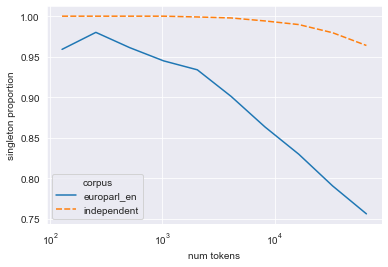

In [5]:
%matplotlib inline
from testperanto.analysis import plot_singleton_proportion
from testperanto.util import stream_lines

independent = generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=100000)
europarl_en = stream_lines('../data/europarl.en.amod.100k.txt')
plot_singleton_proportion([europarl_en, independent], ['europarl_en', 'independent'])

Looks like generating the adjectives and nouns independently doesn't look language-like at all!
The "real English" Europarl curve shows a steady log-linear degradation in singleton proportion, while the "generated English" curve does not.

The problem is the fact that we're generating adjectives and nouns from independent distributions. Just because the adjective `red` is more likely than the adjective `yellow`, that shouldn't mean that the bigram `red banana` is more likely than the bigram `yellow banana`. 

It would be nice if we could generate the adjective from a distribution that depends on the choice of noun. Luckily we can use our y- and z-variables to do so! In addition to our independent noun and adjective distributions, we introduce a **distribution macro** `adj.$y1` that generates distributions that are dependent on the choice of noun `$y1`. For instance, `adj.1` will be the adjective distribution we use for `noun.1`, `adj.2` will be the adjective distribution we use for `noun.2`. To ensure that each distribution still uses the same set of adjectives, each distribution `adj.$y1` is a Pitman-Yor process whose base distribution is `adj` (this happens implicitly -- `testperanto` assumes that the base distribution of a distribution named `a.b.c` is `a.b` and the base distribution of a distribution named `a.b.` is `a`).



In [8]:
config = {"grammar": [
            {"rule": "START -> NP.$z1", "zdists": ["nn"]},
            {"rule": "NP.$y1 -> ADJ.$z1 NN.$y1", "zdists": ["adj.$y1"]},
            {"rule": "NN.$y1 -> (@nn (STEM noun.$y1) (COUNT sng))"},
            {"rule": "ADJ.$y1 -> (@adj (STEM adj.$y1))"}
          ],
          "distributions": [
            {"name": "nn", "type": "pyor", "discount": 0.4, "strength": 500.0},
            {"name": "adj", "type": "pyor", "discount": 0.4, "strength": 500.0},
            {"name": "adj.$y1", "type": "pyor", "discount": 0.6, "strength": 2.0}
          ]}
generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=5)


100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2345.02it/s]


['miglahocugish dobahin',
 'lafrudish goglur',
 'guchijijamish golomiguk',
 'fachihogish bofriflukeed',
 'keechibibish johabum']

It turns out that these newly dependent adjective-noun pairs do a much better job of emulating the singleton proportion statistics of natural language.

100%|██████████████████████████████████████████| 100000/100000 [00:39<00:00, 2541.44it/s]
3it [00:00, 17.49it/s]


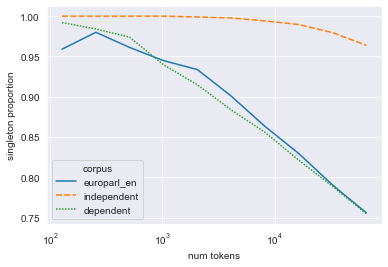

In [7]:
dependent = generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=100000)
europarl_en = stream_lines('../data/europarl.en.amod.100k.txt')
plot_singleton_proportion([europarl_en, independent, dependent], ['europarl_en', 'independent', 'dependent'])